# Documentation for pseudo_sql

### DEPENDECIES 

In [857]:
%matplotlib inline

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from compytibility_pack.format_string import *

### FUNCTIONS 

### findKey function


In [130]:
def findKey(_dict, find = 'min'):
    '''findKey function
    '''
    keys = list(_dict.keys())
    val  = list(_dict.values())
    if find == 'min':
        return keys[np.argmin(val)]
    if find == 'max':
        return keys[np.argmax(val)]
    
minValue = lambda _dict: findKey(_dict, 'min')
maxValue = lambda _dict: findKey(_dict, 'max')

In [131]:
test_dict = {'a':1, 'b':20, 'c':4, 'd':-7}

In [132]:
maxValue(test_dict)

'b'

### saveRelation

In [838]:
def saveRelation(arr, _path):
    '''
    '''
    np.save(_path+'relation_scheme', arr)
    

In [869]:
rel_sch =['Users--1n--UserTeam', 'Teams--1n--UserTeam','Role--1n--UserTeam','Activities--1n--Teams']
saveRelation(rel_sch, 'sql_example/')

In [840]:
def loadRelation(_path):
    return list(np.load(_path+'relation_scheme.npy'))

In [870]:
loadRelation('sql_example/')

['Users--1n--UserTeam',
 'Teams--1n--UserTeam',
 'Role--1n--UserTeam',
 'Activities--1n--Teams']

### CLASSES 

### database 
Database class. 

In [831]:
class database:
    
    desc = 'This is a database instance.'
    
    def __init__(self, reference_path = 'sql_like/' , table_names = 'all', relation_scheme = []):
        '''init
        ---- inputs
        db: list containing table names 
        relation_scheme: list containing the relations among tables as string
        '''
        self.reference_path = reference_path
        
        db = {}
        for i in table_names:
            db[i] = reference_path+i+'.csv'
        
        self.ref = db
        
        self.relation_scheme = relation_scheme
        self.fast_read = False 
        
        const_dict = {}
        if type(db) == type(''):
            
            # search tables under subdir named sql_like (save names)
            
            # create dictionary 
            
            # save results 
            print('TODO.')
    
    def availableTables(self, silence = False, ret_rn = False):
        '''availableTables functions
        
        ---- inputs 
        
        ---- outputs
        
        '''
        table_names = []
        for i in self.ref.keys():
            table_names.append(i)
            if not silence:
                print(i)
        if ret_rn:
            return table_names

        
    def updateFastRead(self):
        '''updateFastRead
        '''
        pass
        
    def getCols(self, table_pd, table_name = '', colnames = []):
        '''getCols
        Query columns 
        
        ---- inputs 
        
        ---- outputs 
        
        '''
        
        cn   = []
        for col in colnames:
            
            # check if a specif table was requested
            '''
            if '.' in col:
                col = col.split('.')
                if col[0] != table_name:
                    continue
                col = col[1]
            '''
            
            # check if column exists 
            if col in table_pd.columns:
                cn.append(col)
                
        return table_pd[cn]
            
    def readTable(self, table, colnames = []):
        '''readTable function
        Read a given table in memory. 
        
        ---- inputs
        table: string containing the table's name.
        
        ---- outputs
        A pandas dataframe with the information of the table.
        '''
        
        # TODO: verify if table exists 
        table_path = self.ref[table]
        
        if len(colnames) == 0:
            if self.fast_read:
                return pd.read_pickle('{}fastread/{}.pkl'.format(self.reference_path,table))
            return pd.read_csv(table_path)
        
        return self.getCols(pd.read_csv(table_path),table_path,colnames)
    
    def createFastRead(self):
        '''createFastRead function
        '''
        
        # create directory 
        # TODO
        
        # get available tables
        at = self.availableTables(silence = True, ret_rn = True)
        
        # save as pickle 
        for table in at: 
            self.readTable(table).to_pickle('{}fastread/{}.pkl'.format(self.reference_path,table))
        
        # enable
        self.fast_read = True 

    def tablesAndCols(self, silence = False, ret_rn = False):
        '''
        '''
        table_list = self.availableTables(silence = True, ret_rn = True)
        
        ref_dict = {}
        for tab in table_list:
            a = self.readTable(tab)
            string = '\n {} :::: {}\n'
            ref_dict[tab] = list(a.columns)
            if not silence:
                print(string.format(tab, ref_dict[tab]))
            
        if ret_rn:
            return ref_dict
    
    def _where(self, table, condition):
        '''_where function
        '''
        
        # one table without condition
        if condition == '':
            return table
        
        return table.query(condition)
            
        
        
    def findRelation(self, table_name1, table_name2, silence = True):
        '''findRelation
        Not efficient. 
        '''
        rs = db.relation_scheme
        
        at = self.availableTables( silence = True, ret_rn = True)
        if (not (table_name1 in at)) or (not (table_name2 in at)):
            if not silence:
                print('Warning: table not in database.')
            #return None
        
        def findAux(val, string):
            st = string.split('--')
            for s in st:
                if val == s:
                    return True
            return False
        
        def findIn(table_name, string):
            for t in table_name.split('REF'):
                if (findAux(t, string)):
                    return True 
            return False
        
        def findInd(t1, t2, string):
            
            rel = string[string.find('--')+2:string.find('--')+4]
            p1 = -1
            p2 = -1
            
            for t in t1.split('REF'):
                if t in string:
                    p1 = string.find(t)
            
            p2 = string.find(t2)
            if p1 > p2:
                return rel[-1]+rel[0]
            return rel 
        
        save_rel = None 
        for r in rs:

            if findIn(table_name1, r) and findIn(table_name2, r):
                save_rel = r
        
        if type(save_rel) == type(None):
            print('Warning: Relation not found.')
            return 0
        
        return findInd(table_name1, table_name2, save_rel)
    
    def constrTable(self, tables):
        '''
        '''
        
        # dictionary of tables and status 
        table_status = {}
        for t in tables:
            table_status[t] = 1
            
        # function to make a table from t1 -- 1n -- t2
        def makeTable(t1, t2, n1, n2):
            
            col1 = t1.columns
            col2 = t2.columns
            
            isId = lambda val: 'id_' in val
            
            def getIds(cols):
                res = []
                for c in cols:
                    if isId(c):
                        res.append(c)
                return res 
            
            idc1 = getIds(col1)
            idc2 = getIds(col2)
            
            
            def repVal(list1, list2):
                for i in list1:
                    if i in list2:
                        return i
            axis_col = repVal(idc1, idc2)
            
            def changeColName(axis_col, colnames,n):
                c = []
                for i in colnames:
                    if len(i.split('REF')) > 1:
                        #i = i.split('REF')[-1]
                        c.append(i)
                        continue
                    if not 'id' in i:
                        c.append(n+'REF'+i)
                    else:
                        c.append(i)
                return c
            
            t1.columns = changeColName(axis_col, col1, n1)
            t2.columns = changeColName(axis_col, col2, n2)
            
            
            def extract(_id):
                return np.asscalar(t1.query('{} == {}'.format(axis_col,_id))[c].values)
            
            
            for c in t1.columns:
                if c == axis_col:
                    continue 
                    
                t2[c] = t2[axis_col].apply(extract)
                
            return t2
        
        # function to check if all status in table_status are zero
        def checkStatus(table_status):
            st = 0
            for k in table_status.keys():
                st += table_status[k]
            if st == 0:
                return True
            return False 
        
        # recursive function to find match and construct final table
        def findMatch(table,table_name,table_status):

            if checkStatus(table_status):
                return table 
            
            for t in table_status.keys():
                # invalid status 
                if not table_status[t]:
                    continue
                # skip same 
                if t == table_name:
                    table_status[t] = 0
                    continue 
                # determine relation
                rel = self.findRelation(table_name, t)
                if type(rel) == type(None):
                    continue
                break
            
            if type(rel) == type(None):
                return table
            
            rel = self.findRelation(table_name,t)
            new_name = table_name+'REF'+t
            
            if rel == '1n':
                table_status[t] = 0
                new_table = makeTable(table, self.readTable(t), table_name, t)
                
            if rel == 'n1':
                table_status[t] = 0
                new_table = makeTable(self.readTable(t),table,t, table_name)
                
            table_status[new_name] = 0
            
            final_table = findMatch(new_table,new_name,table_status)
            return final_table
        
        table_status[tables[0]] = 0
        temp = findMatch(self.readTable(tables[0]),tables[0],table_status)
        return temp
        
    def SELECT(self, colnames = [], _as = [], FROM = [], WHERE = '', _reset = True):
        '''SELECT function
        add desc.
        
        ---- inputs
        colnames: list containing string 
        ''' 
        
        # function to relapce dots in a string by 'REF'
        # e.g. "this is a string with a dot (.)" --> "this is a string with a dot (REF)"
        def replaceDotByREF(string):
            string = string.split('.')
            if len(string) > 1:
                tail = ''
                for i in string[1:]:
                    tail += 'REF'+i
                new_string = string[0]+tail
                return replaceDotByREF(new_string)
            return string[0]
            
        # format colnames 
        new_colnames = []
        for c in colnames:
            new_colnames.append(replaceDotByREF(c))  
        colnames = new_colnames 
        
        # format where statement
        WHERE = replaceDotByREF(WHERE)
        
            
        if len(FROM) == 1:
            return self.getCols(
                         self._where(
                             self.readTable(FROM[0], colnames = []), 
                             WHERE),colnames = colnames)
        
        if len(_as) == 0:
            _as = colnames
        else:
            new_as = []
            for i,j in zip(colnames, _as):
                if j == '':
                    new_as.append(i)
                else:
                    new_as.append(j)
                    
        tbl = self.getCols(self._where(self.constrTable(FROM), WHERE),colnames = colnames)
        tbl.columns = new_as
        
        if _reset:
            tbl.reset_index(inplace = True, drop = True)
            
        return tbl
        

Initialize a database instance by specifying the reference path for the tables (in  csv), the table names and the relation scheme. 

In [946]:
db = database(
    reference_path  = 'sql_example/',
    table_names     = ['Users', 'Teams','UserTeam','Role','Activities'],
    relation_scheme = loadRelation('sql_example/')
)

Create and enable "fast read" to copy the .csv files into a subdirectoy with .pkl format to improve reading performance. 

In [947]:
db.createFastRead()

Check the tables available in the database instance and the relation scheme. 

In [948]:
string = '\nAvailable tables:\n\n>> {}\n\n Relation Scheme:\n\n>> {}'

print(formatString(string,
                   [db.availableTables(silence=True,ret_rn=True),
                    db.relation_scheme]))


Available tables:

>> ['UserTeam', 'Teams', 'Role', 'Activities', 'Users']

 Relation Scheme:

>> ['Users--1n--UserTeam', 'Teams--1n--UserTeam', 'Role--1n--UserTeam', 'Activities--1n--Teams']


View the columns for each table. 

In [949]:
db.tablesAndCols()


 UserTeam :::: ['id_userteam', 'id_user', 'id_team', 'id_role']


 Teams :::: ['id_team', 'id_activity', 'color', 'score']


 Role :::: ['id_role', 'description']


 Activities :::: ['id_activity', 'description']


 Users :::: ['id_user', 'name', 'sex', 'age', 'weight', 'height', 'nationality', 'ethnic']



Handle tables in memory as pandas objects. This allwos a higher level of data manipulation.

In [950]:
db.readTable('Users')

,id_user,name,sex,age,weight,height,nationality,ethnic
0,1,Ana,Female,21,54,1.69,mexican,latin
1,2,Rodrigo,Male,22,76,1.75,mexican,latin
2,3,Daniel,Male,20,74,7.70,mexican,latin
3,4,Manuel,Male,15,56,1.76,mexican,latin
4,5,Gabriela,Female,16,43,1.53,mexican,latin
5,6,Jaquelin,Female,15,53,1.64,mexican,latin
6,7,Teresa,Female,24,55,1.68,mexican,latin


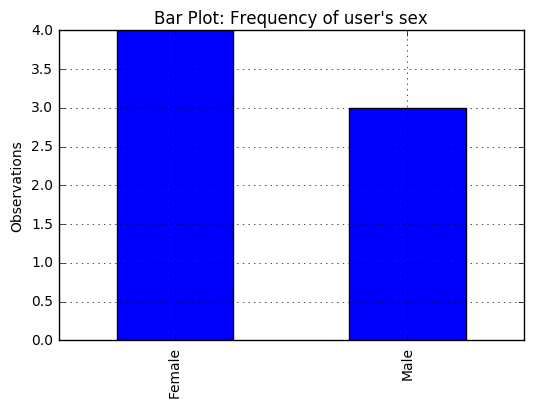

In [951]:
db.readTable('Users').sex.value_counts().plot(kind = 'bar')
plt.title("Bar Plot: Frequency of user's sex")
plt.ylabel('Observations')
plt.grid()

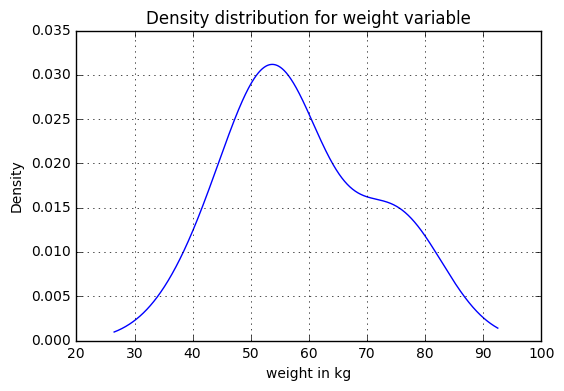

In [952]:
db.readTable('Users').weight.plot(kind = 'kde')
plt.title('Density distribution for weight variable')
plt.xlabel('weight in kg')
plt.grid()

Find relation among two tables. 

In [953]:
table_test1, table_test2 = 'Role', 'UserTeam'

string = 'The relation between "{}" and "{}" is {}.'
print(stringFormat(string, [table_test1, table_test2, db.findRelation(table_test1, table_test2)]))


The relation between "Role" and "UserTeam" is 1n.


"Construct" or join two tables by using their "axis_column" (common id column between both).

**Note** REF as reference. 

In [954]:
print(stringFormat('\n{}\n\n{}',[db.readTable('Teams'),db.readTable('Activities')]))



   id_team  id_activity  color  score
0        1            1  green     10
1        2            2   blue      5
2        3            3    red      8

   id_activity                 description
0            1               just have fun
1            2  program a self-driving car
2            3    organize a balloon-party


In [955]:
db.constrTable(['Teams', 'Activities'])

,id_team,id_activity,TeamsREFcolor,TeamsREFscore,ActivitiesREFdescription
0,1,1,green,10,just have fun
1,2,2,blue,5,program a self-driving car
2,3,3,red,8,organize a balloon-party


Simulate sql query style.

In [956]:
db.SELECT(colnames = ['Users.name', 'Teams.color'], 
          _as      = ["User's Name","Team color"],
          
          FROM     = ['Users', 'UserTeam','Teams'], 
          WHERE    = ''
          
         )


,User's Name,Team color
0,Ana,green
1,Rodrigo,green
2,Daniel,blue
3,Manuel,blue
4,Manuel,red
5,Gabriela,red
6,Jaquelin,red
7,Gabriela,blue


In [957]:
db.SELECT(colnames = ['Users.name','Role.description','Teams.color', 'Activities.description'], 
          _as      = ['Name','Role','Team color','General Activity'],
          
          FROM     = ['Users','UserTeam', 'Role','Teams','Activities'], 
          WHERE    = 'Teams.color == "green"'
          
         )

,Name,Role,Team color,General Activity
0,Ana,secretary,green,just have fun
1,Rodrigo,team leader,green,just have fun
